In [1]:
from time import time
start_time = time()

### Imports

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import libpysal as ps
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import math
import matplotlib.pyplot as plt
from time import time
import esda
import contextily as ctx

### Load and prepare data

In [3]:
# BIG DATASET
# Split 1
#housestrain = gpd.read_file(
#    r"Y:\Lukas\thesis\bus1123\data\split1\calhouses3310scat-train1-voro.shp")
#housestest = gpd.read_file(
#    r"Y:\Lukas\thesis\bus1123\data\split1\calhouses3310scat-test1.shp")

# Split 2
#housestrain = gpd.read_file(
#    r"Y:\Lukas\thesis\bus1123\data\split2\calhouses3310scat-train2-voro.shp")
#housestest = gpd.read_file(
#    r"Y:\Lukas\thesis\bus1123\data\split2\calhouses3310scat-test2.shp")

# Split 3
#housestrain = gpd.read_file(
#    r"Y:\Lukas\thesis\bus1123\data\split3\calhouses3310scat-train3-voro.shp")
#housestest = gpd.read_file(
#    r"Y:\Lukas\thesis\bus1123\data\split3\calhouses3310scat-test3.shp")

# SMALL DATASET
# Split 1
housestrain = gpd.read_file(
    r"Y:\Lukas\thesis\bus1123\randomsample_houses\houses_random_2050_TRAIN-1_points.shp")
housestest = gpd.read_file(
    r"Y:\Lukas\thesis\bus1123\randomsample_houses\houses_random_2050_TEST-1_points.shp")

# Split 2
#housestrain = gpd.read_file(
#    r"Y:\Lukas\thesis\bus1123\randomsample_houses\houses_random_2050_TRAIN-2_points.shp")
#housestest = gpd.read_file(
#    r"Y:\Lukas\thesis\bus1123\randomsample_houses\houses_random_2050_TEST-2_points.shp")

# Split 3
#housestrain = gpd.read_file(
#    r"Y:\Crime_HU\bus1123\randomsample_houses\houses_random_2050_TRAIN-3_points.shp")
#housestest = gpd.read_file(
#    r"Y:\Crime_HU\bus1123\randomsample_houses\houses_random_2050_TEST-3_points.shp")

print(housestrain.shape)
print(housestest.shape)
housestrain.head(2)

(1640, 8)
(411, 8)


,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry
0,280200.0,5.0294,27.0,1176.0,416.0,6.427885,1.007212,POINT (18374.356 -397330.047)
1,329500.0,3.5652,27.0,1278.0,565.0,4.357522,1.008850,POINT (-172576.363 -76748.586)


In [4]:
housestest.head(2)

,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry
0,55000.0,1.6071,27.0,587.0,231.0,4.190476,1.038961,POINT (-6223.359 -116314.796)
1,104200.0,2.1250,16.0,1077.0,520.0,5.046154,1.013462,POINT (60108.280 -192791.957)


### Define dependent and independent variables

In [5]:
# X = independent; y = dependent
X_train = housestrain.drop(["MedHouseVa", "geometry"], axis=1)
y_train = housestrain['MedHouseVa']

X_test = housestest.drop(["MedHouseVa", "geometry"], axis=1)
y_test = housestest['MedHouseVa']

In [6]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (1640, 6)
Training Labels Shape: (1640,)
Testing Features Shape: (411, 6)
Testing Labels Shape: (411,)


### "Raw" Random Forest Regression - to show influence HPO has

In [7]:
#%%time
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)

errors = abs(predictions - y_test)

print('MAE:', round(np.mean(errors), 2), 'units.')
r2 = round(r2_score(y_test, predictions), 2)
print("R2: ", r2)
mse = mean_squared_error(y_test, predictions)
print("MSE: ", mse)
print("RMSE: ", math.sqrt(mse))

MAE: 51936.2 units.
R2:  0.63
MSE:  4902009536.704363
RMSE:  70014.3523622433


### HPO - random search

In [8]:
param_dist = {
    'n_estimators': np.arange(50, 210, 10),
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None] + list(np.arange(10, 110, 10)),
    'min_samples_split': np.arange(2, 12),
    'min_samples_leaf': np.arange(1, 5),
    'bootstrap': [True, False]
}

In [9]:
#%%time
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, scoring='neg_mean_squared_error', 
    cv=5, n_iter=20, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'n_estimators': 170, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}


### Build RF with best params and predict on test data

In [10]:
#%%time
best_rf = RandomForestRegressor(**random_search.best_params_, random_state=42, n_jobs=-1)
best_rf.fit(X_train, y_train)
predictions = best_rf.predict(X_test)

### Calculate Evaluation Metrics

In [11]:
print('MAE:', round(np.mean(abs(predictions - y_test)), 2), 'units.')
print("R2: ", round(r2_score(y_test, predictions), 3))
print("MSE: ", mean_squared_error(y_test, predictions))
print("RMSE: ", np.sqrt(mean_squared_error(y_test, predictions)))
print("Time for RF + pred: {:.2f} seconds".format(time() - start_time))

MAE: 52382.95 units.
R2:  0.636
MSE:  4854454883.753803
RMSE:  69673.9182460252
Time for RF + pred: 9.03 seconds


### LISA

In [12]:
#Calculation of TEST ERROR 
housestest['predictions'] = predictions.flatten()
housestest['y_test'] = y_test
housestest['test_res'] = housestest['y_test'] - housestest['predictions']

print(housestest.shape)
housestest.head(1)

(411, 11)


,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry,predictions,y_test,test_res
0,55000.0,1.6071,27.0,587.0,231.0,4.190476,1.038961,POINT (-6223.359 -116314.796),106924.076797,55000.0,-51924.076797


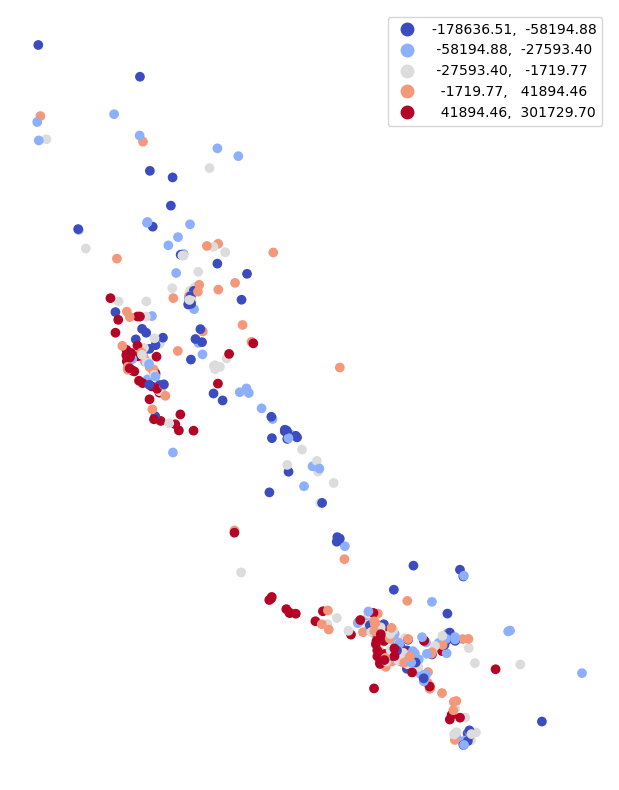

In [13]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'aspect': 'equal'})
housestest.plot(column='test_res', scheme='Quantiles', k=5, 
                cmap='coolwarm', legend=True, ax=ax)
ax.set_axis_off()
plt.show()

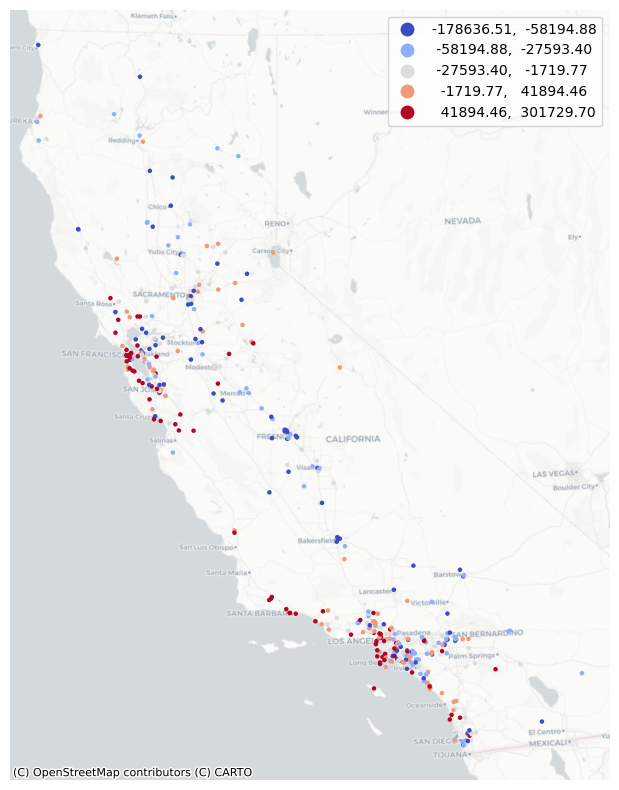

In [14]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'aspect': 'equal'})
housestest.plot(column='test_res', scheme='Quantiles', k=5,
                cmap='coolwarm', legend=True, ax=ax, markersize=5)
ctx.add_basemap(ax, crs=housestest.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
save_path = r'Y:\Lukas\thesis\regionalization plots/basemap_RF.png'
#plt.savefig(save_path)
plt.show()

In [15]:
# new spatial weights for moran's I
wi = ps.weights.distance.KNN.from_dataframe(housestest, k=6) 
wi.transform = 'r'
y = housestest['test_res']

In [16]:
mi = esda.Moran(y, wi, permutations = 1000, two_tailed=False)
print( 'Moran I is', round(mi.I, 3), '; p-value is', mi.p_sim, '; expected value is', mi.EI)

Moran I is 0.294 ; p-value is 0.000999000999000999 ; expected value is -0.0024390243902439024


In [17]:
# Calculate LISA
lisa = esda.moran.Moran_Local(y, wi)

In [18]:
# Calculate spatial groupings and significance
housestest['Is'] = lisa.Is
housestest['pvalue'] = lisa.p_sim 
housestest['group'] = lisa.q 
housestest.loc[housestest['pvalue'] > 0.05, 'group'] = 'not-significant'
housestest.loc[housestest['group'] == 1, 'group'] = 'hotspot'
housestest.loc[housestest['group'] == 2, 'group'] = 'cold outlier'
housestest.loc[housestest['group'] == 3, 'group'] = 'coldspot'
housestest.loc[housestest['group'] == 4, 'group'] = 'hot outlier'
print(housestest ['group'].value_counts())
housestest.head(2)

group
not-significant    279
coldspot            56
hotspot             50
cold outlier        14
hot outlier         12
Name: count, dtype: int64


C:\Users\lukasb97\AppData\Local\Temp\ipykernel_19528\1113662505.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'not-significant' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  housestest.loc[housestest['pvalue'] > 0.05, 'group'] = 'not-significant'


,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry,predictions,y_test,test_res,Is,pvalue,group
0,55000.0,1.6071,27.0,587.0,231.0,4.190476,1.038961,POINT (-6223.359 -116314.796),106924.076797,55000.0,-51924.076797,0.711765,0.002,coldspot
1,104200.0,2.1250,16.0,1077.0,520.0,5.046154,1.013462,POINT (60108.280 -192791.957),109003.426237,104200.0,-4803.426237,0.006185,0.141,not-significant


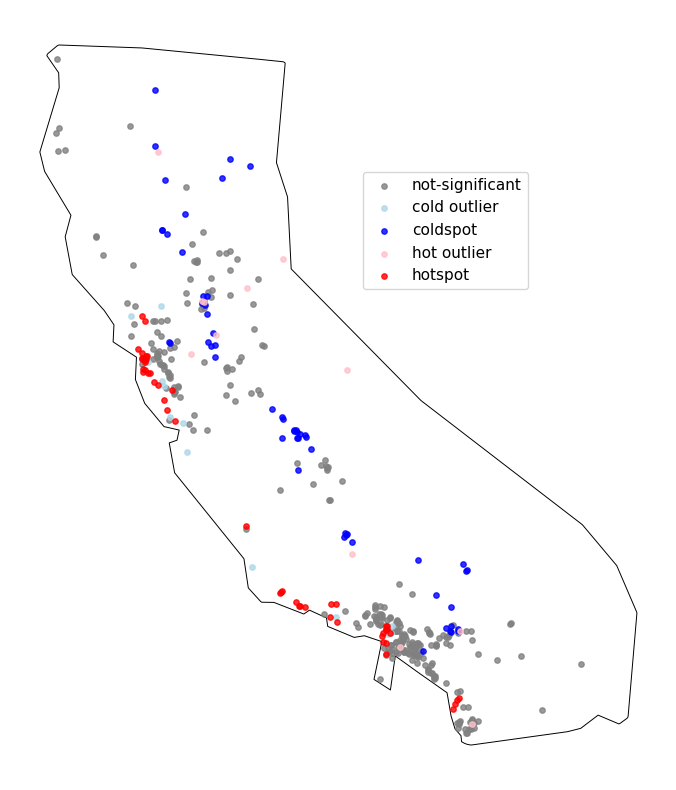

In [19]:
state_boundary = gpd.read_file(r"Y:/Lukas/thesis/bus1123/bufferedcliprahmen.shp")
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'aspect':'equal'})    

group_colors = {'not-significant': 'grey',
               'hotspot': 'red',
               'coldspot': 'blue',
               'cold outlier': 'lightblue',
               'hot outlier': 'pink'}

state_boundary.plot(ax=ax, edgecolor='black', linewidth=0.7, facecolor='none')

for ctype, data in housestest.groupby('group'):
    if ctype == 'not-significant':
        color = group_colors[ctype]
        data.plot(color=color, ax=ax, label=ctype, markersize=15, alpha=0.8)

for ctype, data in housestest.groupby('group'):
    if ctype != 'not-significant':
        color = group_colors[ctype]
        data.plot(color=color, ax=ax, label=ctype, markersize=15, alpha=0.8)

ax.legend(bbox_to_anchor=(0.8, .8), prop={'size': 11})

ax.set_axis_off()
save_path = r'Y:\Lukas\thesis\regionalization plots/lisa_RF_S2_small.png'
#plt.savefig(save_path)
plt.show()

### Runtime

In [20]:
print("Time for whole script: {:.2f} seconds".format(time() - start_time))

Time for whole script: 16.57 seconds
